# Dataset construction

In [1]:
import torch 
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib.gridspec import GridSpec
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from os.path import join
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cityblock
import tkinter as tk
from tkinter import filedialog, messagebox

np.random.seed(1328)
torch.random.manual_seed(1328)
class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']


In [2]:

#FUNZIONE PER CARICARE IL DATASET DI IMMAGINI

def load_images_from_subfolders(main_folder):
    data = []
    label_names = {}
    label_index = 0    
    # Loop through each subject folder
    for subject_folder in os.listdir(main_folder):
        subject_path = os.path.join(main_folder, subject_folder)
        if os.path.isdir(subject_path):
            # Loop through each letter subfolder
            for letter_folder in os.listdir(subject_path):  # Correzione qui
                letter_path = os.path.join(subject_path, letter_folder)
                if os.path.isdir(letter_path):
                    # Get or create a label index for the letter
                    if letter_folder not in label_names:
                        label_names[letter_folder] = label_index
                        label_index += 1
                    label = label_names[letter_folder]
                    
                    # Load each image in the letter subfolder
                    for filename in os.listdir(letter_path):
                        img = cv2.imread(os.path.join(letter_path, filename), cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, (100, 100)) 
                            data.append({'image': img, 'label': label, 'letter': letter_folder, 'subject': subject_folder})
    
    return pd.DataFrame(data), label_names, class_names

def prepare_data(df):
    # Expand the dimensions of images to add the channel dimension
    df['image'] = df['image'].apply(lambda x: x[:, :, np.newaxis])
    
    # Convert labels to one-hot encoding
    labels = to_categorical(df['label'], num_classes=df['label'].nunique())
    df['label'] = list(labels)
    
    return df

#CREAZIONE TEST E TRAIN SET
def create_train_test_dataframe(df, test_size=0.2):
    # Split the dataset into training and testing sets
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=42, stratify=df['label'].apply(lambda x: np.argmax(x)))
    
    print(f"Train set: {df_train.shape}, Test set: {df_test.shape}")
    
    return df_train, df_test

#PLOT CLASS DISTRIBUITION
def plot_class_distribution(df, title, alphabet):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(15, 6))
    label_indices = df['label'].apply(lambda x: np.argmax(x))  # Get the original class indices
    label_counts = label_indices.value_counts().reindex(range(len(alphabet)), fill_value=0)
    
    ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)
    ax.set_title(f"Distribution of Samples in {title} Data", fontsize=16, fontweight='bold')
    ax.set_xlabel("Class", fontsize=14)
    ax.set_ylabel("Number of Samples", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'plots/distribution_{title}_data.png')

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)
    plt.show()

#per plottare alcune immagini di esempio
def plot_sample_images(df_train, alphabet):
    fig = plt.figure(figsize=(9, 9))
    gs = GridSpec(3, 3, figure=fig)  # Griglia 3x3

    # Convert one-hot encoded labels back to integers for uniqueness
    df_train['label_int'] = df_train['label'].apply(lambda x: np.argmax(x))
    unique_labels = df_train['label_int'].unique()[:3]  # Limita a 3 categorie

    for i, category in enumerate(unique_labels):
        sample_images = df_train[df_train['label_int'] == category].sample(min(3, len(df_train[df_train['label_int'] == category])))
        for j, (index, row) in enumerate(sample_images.iterrows()):
            ax = fig.add_subplot(gs[i, j])
            img = row['image'].reshape(100, 100)  # Assuming the images are 64x64
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.text(0.5, -0.1, alphabet[category], fontsize=25, color='black', ha='center', transform=ax.transAxes)
    plt.show()

In [3]:
main_folder = 'dataset'
df, label_names, alphabet = load_images_from_subfolders(main_folder)
df = prepare_data(df)
df_train, df_test = create_train_test_dataframe(df)

Train set: (15280, 4), Test set: (3821, 4)


C:\Users\orazi\AppData\Local\Temp\ipykernel_11736\2206875324.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)


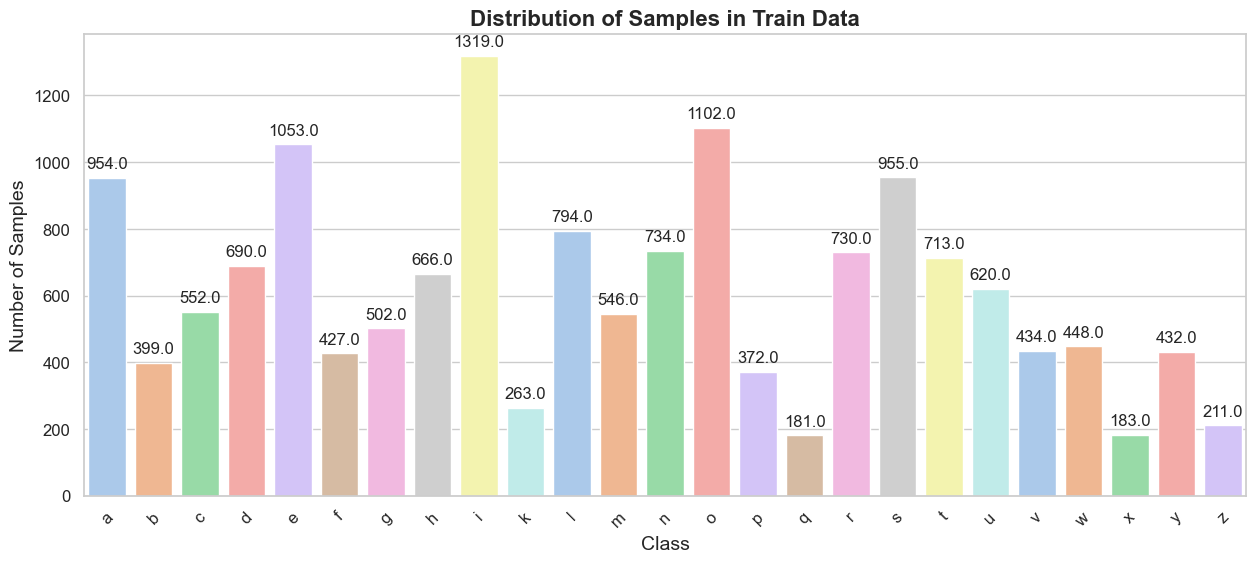

C:\Users\orazi\AppData\Local\Temp\ipykernel_11736\2206875324.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)


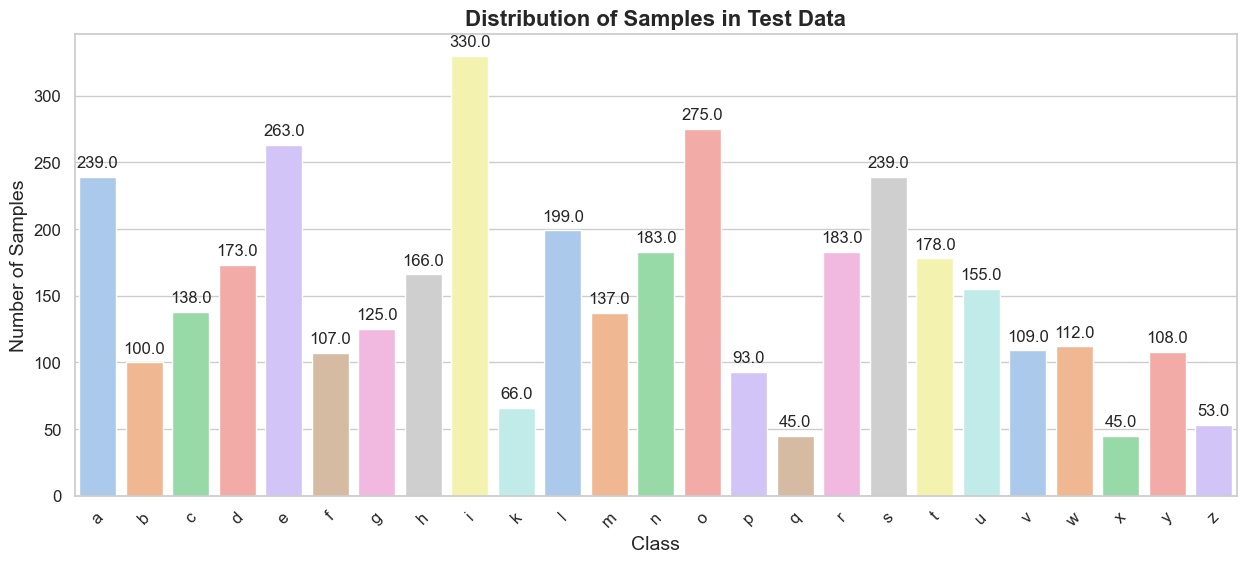

In [4]:
plot_class_distribution(df_train, 'Train', alphabet)
plot_class_distribution(df_test, 'Test', alphabet)

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment=False):
        self.transform = transform
        self.augment = augment
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(dataframe['label_int'].unique())}
        if self.augment:
            self.dataframe = pd.concat([dataframe, dataframe]).reset_index(drop=True)
        else:
            self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_array = row['image']
        if len(image_array.shape) == 3 and image_array.shape[2] == 1:
            image_array = image_array.squeeze(-1)  
        image = Image.fromarray(image_array.astype(np.uint8)).convert('RGB')  
        label = row['label_int']

        if self.transform:
            image = self.transform(image)

        return image, label

def collate_fn(batch):
    images, labels, subjects = zip(*batch)
    return torch.stack(images), torch.tensor(labels), subjects

# Define transformations
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop((50, 50)), 
    transforms.RandomAffine(30),  
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

val_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

df_train['label_int'] = df_train['label'].apply(lambda x: np.argmax(x))

# Split dataset into training, testing, and validation
train_df, test_val_df = train_test_split(df_train, test_size=0.4, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

train_dataset = CustomDataset(train_df, transform=train_transform, augment=True)
val_dataset = CustomDataset(val_df, transform=val_transform)
test_dataset = CustomDataset(test_df, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [6]:
# Training data
print(f"Training Samples ({len(train_dataset)})")
inputs, classes = next(iter(train_loader))
print("Shape:", inputs.shape)

# Validation data
print(f"Validation Samples ({len(val_dataset)})")
inputs, classes = next(iter(val_loader))
print("Shape:", inputs.shape)

# Testing data
print(f"Testing Samples ({len(test_dataset)})")
inputs, classes = next(iter(test_loader))
print("Shape:", inputs.shape)

Training Samples (18336)
Shape: torch.Size([64, 3, 50, 50])
Validation Samples (3056)
Shape: torch.Size([64, 3, 50, 50])
Testing Samples (3056)
Shape: torch.Size([64, 3, 50, 50])


## Letter-Classifier model

In [7]:
class AverageValueMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.n = 0

    def add(self, value, n):
        self.sum += value * n
        self.n += n

    def value(self):
        return self.sum / self.n if self.n > 0 else 0

In [8]:
class LetterClassifier(nn.Module):
    
    def __init__(self, input_shape=(50, 50, 3), num_classes=25, dropout_rate=0.5):
        super(LetterClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # convolutional layer 1
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # convolutional layer 2
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # convolutional layer 3
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # convolutional layer 4
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 512), # fully connected layer
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(512, num_classes) # output layer (fully connected)
        )

    def forward(self, x):
        return self.model(x)

    def numparams(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def train_model(self, train_loader, val_loader, exp_name='experiment', epochs=10, lr=0.001, momentum=0.9, weight_decay=1e-4, logdir='logs', verbose=True, save_model=True):
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)  

        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        loss_meter = AverageValueMeter()
        acc_meter = AverageValueMeter()
        writer = SummaryWriter(join(logdir, exp_name))

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        loader = {'train': train_loader, 'val': val_loader}

        global_step = 0
        best_val_loss = float('inf')
        epochs_no_improve = 0  
        patience = 10
        for e in range(epochs):
            print(f'[Epoch {e+1}/{epochs}]')
            for mode in ['train', 'val']:
                loss_meter.reset()
                acc_meter.reset()
                self.model.train() if mode == 'train' else self.model.eval()

                with torch.set_grad_enabled(mode == 'train'):
                    for i, batch in enumerate(loader[mode]):
                        X = batch[0].to(device)
                        y = batch[1].to(device)
                        out = self.model(X)

                        n = X.shape[0]
                        global_step += n
                        l = loss_fn(out, y)

                        if mode == 'train':
                            l.backward()
                            optimizer.step()
                            optimizer.zero_grad()

                        loss_meter.add(l.item(), n)
                        acc = accuracy_score(y.to('cpu'), out.to('cpu').max(1)[1])
                        acc_meter.add(acc, n)

                        if mode == 'train':
                            writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                            writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)

                    writer.add_scalar('loss/' + mode, loss_meter.value(), global_step=global_step)
                    writer.add_scalar('accuracy/' + mode, acc_meter.value(), global_step=global_step)

                    if mode == 'train':
                        train_losses.append(loss_meter.value())
                        train_accuracies.append(acc_meter.value())
                    else:
                        val_losses.append(loss_meter.value())
                        val_accuracies.append(acc_meter.value())

                        if val_losses[-1] < best_val_loss:
                            best_val_loss = val_losses[-1]
                            epochs_no_improve = 0  
                            if save_model:
                                torch.save(self.model.state_dict(), os.path.join('models', f'{exp_name}.pth'))
                                with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
                                    pickle.dump({
                                        'train_loss': train_losses, 
                                        'val_loss': val_losses,
                                        'train_accuracy': train_accuracies, 
                                        'val_accuracy': val_accuracies
                                    }, f)
                        else:
                            epochs_no_improve += 1 

            if verbose:
                print(f'Train Loss: {train_losses[-1]:.3f}, Train Accuracy: {train_accuracies[-1]:.3f} | Val Loss: {val_losses[-1]:.3f}, Val Accuracy: {val_accuracies[-1]:.3f}\n')

            if epochs_no_improve == patience:
                print('Early stopping')
                break

        return train_losses, train_accuracies, val_losses, val_accuracies

    def test_model(self, test_loader):
        self.model.eval()
        loss_fn = nn.CrossEntropyLoss()
        loss_meter = AverageValueMeter()
        acc_meter = AverageValueMeter()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        with torch.no_grad():
            for batch in test_loader:
                X = batch[0].to(device)
                y = batch[1].to(device)
                out = self.model(X)

                n = X.shape[0]
                l = loss_fn(out, y)

                loss_meter.add(l.item(), n)
                acc = accuracy_score(y.to('cpu'), out.to('cpu').max(1)[1])
                acc_meter.add(acc, n)

        test_loss = loss_meter.value()
        test_accuracy = acc_meter.value()

        return test_loss, test_accuracy

    def test_error(self, test_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        predictions, labels = [], []  # Inizializza come liste vuote
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device)
                y = batch[1].to(device)
                output = self.model(x)
                preds = output.to('cpu').max(1)[1].numpy()
                labs = y.to('cpu').numpy()
                predictions.extend(list(preds))
                labels.extend(list(labs))
        error = (1 - accuracy_score(np.array(labels), np.array(predictions))) * 100
        return error
    
    def evaluate(self, test_loader):
        self.model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.view(-1).cpu().numpy())
        
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')
        
        return precision, recall, f1
    
    def confusion_matrix(self, test_loader):
        self.model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.view(-1).cpu().numpy())
        
        return confusion_matrix(all_labels, all_preds)
    
    def plot_precision_recall_curve(self, test_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.eval()
        self.to(device)
        
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        all_labels_bin = label_binarize(all_labels, classes=np.unique(all_labels))
        n_classes = all_labels_bin.shape[1]
        
        class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']
        
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
            auc_score = auc(recall, precision)
            print(f'AUC per la classe {class_names[i]}: {auc_score:.3f}')



In [9]:
letter_classifier = LetterClassifier()
print(f'The model has {letter_classifier.numparams()} trainable parameters')

The model has 1582361 trainable parameters


## Train the model

In [28]:
lr = 0.001
momentum = 0.9
weight_decay = 0.0001
dropout_rate = 0.2

exp_name = 'letter_classifier_1'
epochs = 200

letter_classifier = LetterClassifier()

'''
train_losses, train_accuracies, test_losses, test_accuracies = letter_classifier.train_model(train_loader,
                                                                                          val_loader,
                                                                                          exp_name=exp_name,
                                                                                          epochs=epochs,
                                                                                          lr=lr,
                                                                                          momentum=momentum,
                                                                                          weight_decay=weight_decay)
'''

'\ntrain_losses, train_accuracies, test_losses, test_accuracies = letter_classifier.train_model(train_loader,\n                                                                                          val_loader,\n                                                                                          exp_name=exp_name,\n                                                                                          epochs=epochs,\n                                                                                          lr=lr,\n                                                                                          momentum=momentum,\n                                                                                          weight_decay=weight_decay)\n'

## Test the model

In [29]:
model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
letter_classifier.model.load_state_dict(model_weights)
letter_classifier.model.eval()

with torch.no_grad():
    test_loss, test_accuracy = letter_classifier.test_model(test_loader)

print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')

Test Loss: 0.788, Test Accuracy: 0.780


In [30]:
test_error = letter_classifier.test_error(test_loader)
print(f"Error percentage: {test_error:.2f} %")

Error percentage: 22.02 %


In [31]:
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)

# Add the new metrics
metrics['test_loss'] = test_loss
metrics['test_accuracy'] = test_accuracy
metrics['test_error'] = test_error

# Save the updated metrics
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

Metrics updated and saved successfully


## After model selection 

In [32]:
# Load the model
letter_classifier = LetterClassifier()
model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
letter_classifier.model.load_state_dict(model_weights)
print("Model loaded successfully")

# Load metrics
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

# Convert the metrics to float and round to 3 decimal places
train_losses = [round(float(i), 3) for i in metrics['train_loss']]
val_losses = [round(float(i), 3) for i in metrics['val_loss']]
train_accuracies = [round(float(i), 3) for i in metrics['train_accuracy']]
val_accuracies = [round(float(i), 3) for i in metrics['val_accuracy']]
test_loss = round(float(metrics['test_loss']), 3)
test_accuracy = round(float(metrics['test_accuracy']), 3)
test_error = round(float(metrics['test_error']), 2)

print(f"Best epoch: {len(val_losses)}/{epochs}\n")
print(f"Train Loss: {train_losses[-1]}")
print(f"Train Accuracy: {train_accuracies[-1]}\n")
print(f"Validation Loss: {val_losses[-1]}")
print(f"Validation Accuracy: {val_accuracies[-1]}\n")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Error: {test_error}%")

Model loaded successfully
Metrics loaded successfully

Best epoch: 135/200

Train Loss: 1.837
Train Accuracy: 0.46

Validation Loss: 0.793
Validation Accuracy: 0.776

Test Loss: 0.788
Test Accuracy: 0.78
Test Error: 22.02%


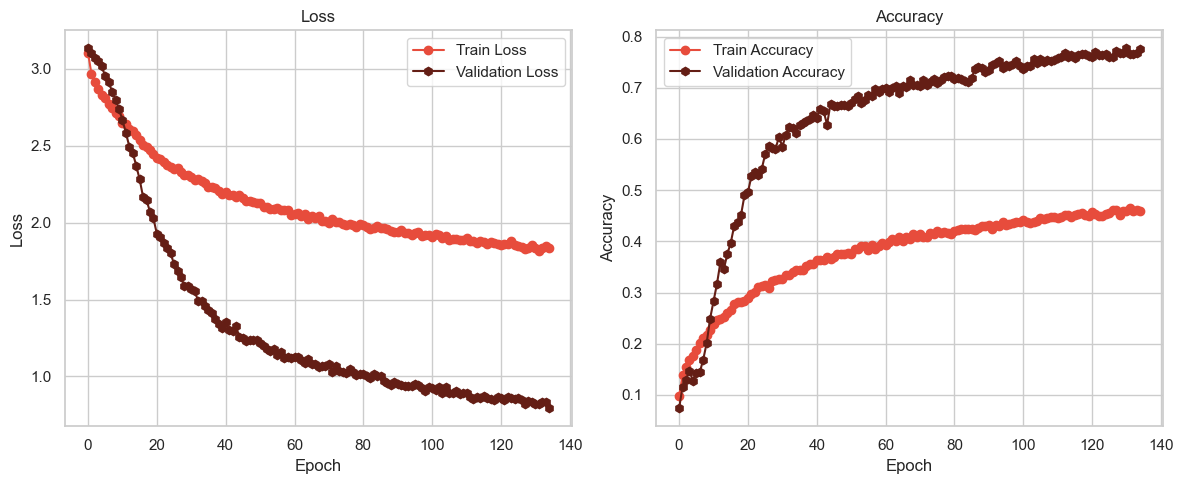

In [33]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, save_path):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, color="#E74C3C", label='Train Loss', marker='o')
    plt.plot(val_losses, color="#641E15", label='Validation Loss', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, color="#E74C3C", label='Train Accuracy', marker='o')
    plt.plot(val_accuracies, color="#641E15", label='Validation Accuracy', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, f'plots/{exp_name}_accuracy_and_Loss.png')

In [34]:
precision, recall, f1 = letter_classifier.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Precision: 0.805
Recall: 0.753
F1 Score: 0.770


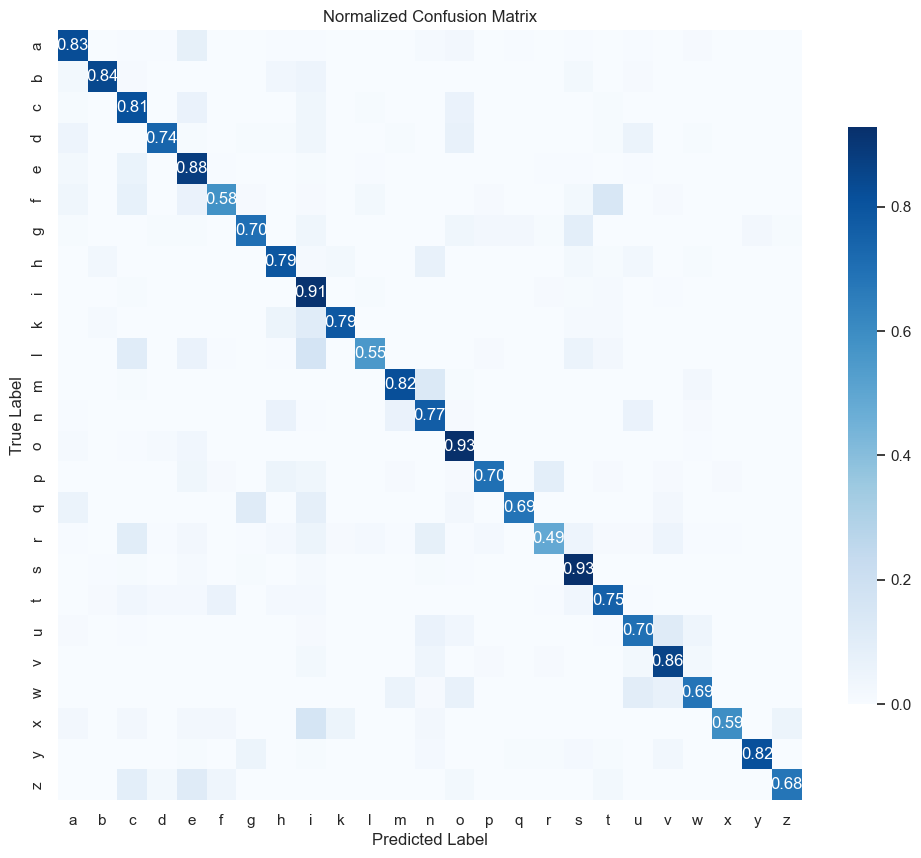

In [35]:
cm = letter_classifier.confusion_matrix(test_loader) 

def plot_normalized_confusion_matrix(cm, class_names, file_path=None):
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create an array of the same shape as cm_normalized filled with empty strings
    annot = np.empty_like(cm_normalized, dtype=object)
    annot[:] = ''

    # Populate the array with the diagonal values as strings
    for i in range(len(cm_normalized)):
        annot[i, i] = f'{cm_normalized[i, i]:.2f}'
    
    plt.figure(figsize=(12, 10))  # Increase figure size
    sns.heatmap(cm_normalized, annot=annot, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 12}, cbar_kws={'shrink': 0.75})  # Adjust text size and color bar
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    if file_path:
        plt.savefig(file_path, bbox_inches='tight')  # Save with tight layout
    plt.show()

plot_normalized_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

In [37]:
letter_classifier.plot_precision_recall_curve(test_loader)


AUC per la classe a: 0.913
AUC per la classe b: 0.886
AUC per la classe c: 0.812
AUC per la classe d: 0.892
AUC per la classe e: 0.926
AUC per la classe f: 0.631
AUC per la classe g: 0.825
AUC per la classe h: 0.892
AUC per la classe i: 0.922
AUC per la classe k: 0.826
AUC per la classe l: 0.831
AUC per la classe m: 0.919
AUC per la classe n: 0.816
AUC per la classe o: 0.935
AUC per la classe p: 0.822
AUC per la classe q: 0.707
AUC per la classe r: 0.759
AUC per la classe s: 0.956
AUC per la classe t: 0.825
AUC per la classe u: 0.797
AUC per la classe v: 0.717
AUC per la classe w: 0.750
AUC per la classe x: 0.790
AUC per la classe y: 0.941
AUC per la classe z: 0.844


## Comparison with Noted Models in the Literature

In [10]:
from torchvision.models import alexnet, vgg16, googlenet, resnet18, squeezenet1_0, AlexNet_Weights, VGG16_Weights, GoogLeNet_Weights, ResNet18_Weights, SqueezeNet1_0_Weights

class GenericModel(LetterClassifier):

    def __init__(self, model_architecture, num_classes=25):
        super(GenericModel, self).__init__(num_classes=num_classes)
        self.model = self.get_model(model_architecture, num_classes)
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        self.model.to(self.device)

    def get_model(self, model_architecture, num_classes):
        if model_architecture == 'alexnet':
            model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        elif model_architecture == 'vgg':
            model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        elif model_architecture == 'googlenet':
            model = googlenet(weights=GoogLeNet_Weights.DEFAULT)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_architecture == 'resnet':
            model = resnet18(weights=ResNet18_Weights.DEFAULT)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
            self.feature_extractor = nn.Sequential(*list(model.children())[:-1])
        elif model_architecture == 'squeezenet':
            model = squeezenet1_0(weights=SqueezeNet1_0_Weights.DEFAULT)
            model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        else:
            raise ValueError(f"Model architecture '{model_architecture}' not recognized")
        return model

    def extract_features(self, x):
        self.model.eval()
        with torch.no_grad():
            features = self.feature_extractor(x)
            features = features.view(features.size(0), -1)
        return features



## Reload datasets

In [11]:
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop((50, 50)), 
    transforms.RandomAffine(30),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

# Split dataset into training, testing, and validation
train_df = df_train
test_df, val_df = train_test_split(df_test, test_size=0.2, random_state=42)

# Add 'label_int' column to test and validation dataframes
test_df['label_int'] = test_df['label'].apply(lambda x: np.argmax(x))
val_df['label_int'] = val_df['label'].apply(lambda x: np.argmax(x))

train_dataset = CustomDataset(train_df, transform=train_transform, augment=True)
val_dataset = CustomDataset(val_df, transform=val_transform)
test_dataset = CustomDataset(test_df, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
# Training data
print(f"Training Samples ({len(train_dataset)})")
inputs, classes = next(iter(train_loader))
print("Shape:", inputs.shape)

# Validation data
print(f"Validation Samples ({len(val_dataset)})")
inputs, classes = next(iter(val_loader))
print("Shape:", inputs.shape)

# Testing data
print(f"Testing Samples ({len(test_dataset)})")
inputs, classes = next(iter(test_loader))
print("Shape:", inputs.shape)

Training Samples (30560)
Shape: torch.Size([64, 3, 224, 224])
Validation Samples (765)
Shape: torch.Size([64, 3, 224, 224])
Testing Samples (3056)
Shape: torch.Size([64, 3, 224, 224])


## AlexNet

In [13]:
alexnet = GenericModel('alexnet')
print(f'The model has {alexnet.numparams()} trainable parameters')

The model has 57106265 trainable parameters


In [14]:
alexnet.eval()
with torch.no_grad():
    alexnet_test_loss, alexnet_test_accuracy = alexnet.test_model(test_loader)
    
print('\nNon fine-tuned AlexNet:')
print(f'Test Loss: {alexnet_test_loss:.3f}, Test Accuracy: {alexnet_test_accuracy:.3f}')


Non fine-tuned AlexNet:
Test Loss: 3.335, Test Accuracy: 0.036


In [13]:

lr = 0.001 
momentum = 0.9
weight_decay = 0.0001 
exp_name = 'alexnet_experiment2'
'''
alexnet_train_losses, alexnet_train_accuracies, alexnet_val_losses, alexnet_val_accuracies = alexnet.train_model(train_loader, 
                                                                                                                 val_loader,
                                                                                                                 exp_name=exp_name, 
                                                                                                                 epochs=1000,
                                                                                                                 lr=lr,
                                                                                                                 momentum=momentum,
                                                                                                                 weight_decay=weight_decay)
'''


'\nalexnet_train_losses, alexnet_train_accuracies, alexnet_val_losses, alexnet_val_accuracies = alexnet.train_model(train_loader, \n                                                                                                                 val_loader,\n                                                                                                                 exp_name=exp_name, \n                                                                                                                 epochs=1000,\n                                                                                                                 lr=lr,\n                                                                                                                 momentum=momentum,\n                                                                                                                 weight_decay=weight_decay)\n'

In [15]:
exp_name = 'alexnet_experiment2'

alexnet.eval()

with torch.no_grad():
    alexnet_test_loss, alexnet_test_accuracy = alexnet.test_model(test_loader)

test_error = alexnet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = alexnet_test_loss
metrics['test_accuracy'] = alexnet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")


# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
alexnet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned AlexNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

Metrics updated and saved successfully
Model loaded successfully
Metrics loaded successfully

Fine-tuned AlexNet:
Train Loss: 0.831
Train Accuracy: 0.743

Validation Loss: 0.307
Validation Accuracy: 0.905

Test Loss: 0.298
Test Accuracy: 0.913


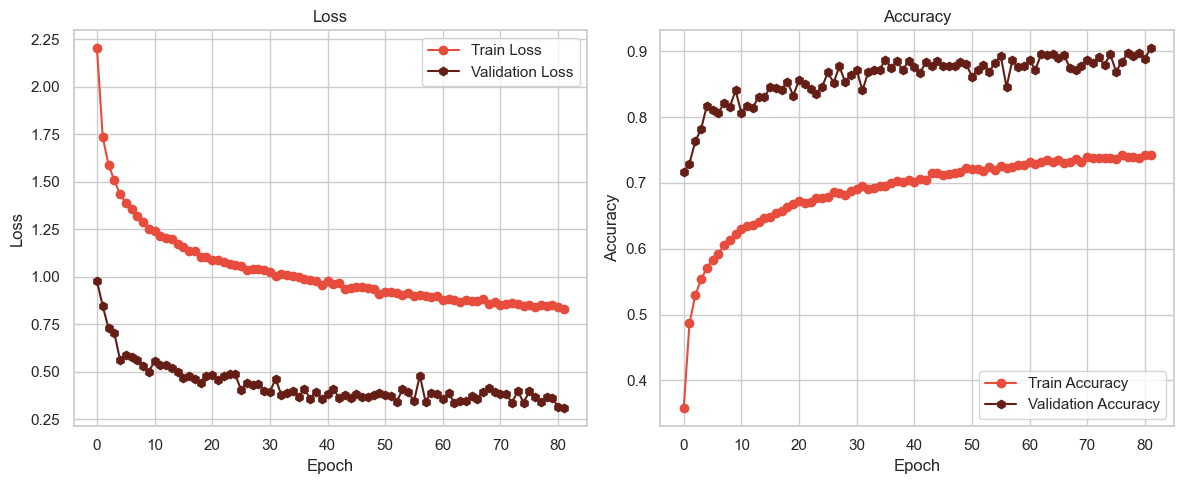

In [16]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, save_path):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, color="#E74C3C", label='Train Loss', marker='o')
    plt.plot(val_losses, color="#641E15", label='Validation Loss', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, color="#E74C3C", label='Train Accuracy', marker='o')
    plt.plot(val_accuracies, color="#641E15", label='Validation Accuracy', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# Ensure train and validation losses and accuracies are lists of float values
train_losses = [float(loss) for loss in metrics['train_loss']]
val_losses = [float(loss) for loss in metrics['val_loss']]
train_accuracies = [float(acc) for acc in metrics['train_accuracy']]
val_accuracies = [float(acc) for acc in metrics['val_accuracy']]

# Plot the metrics
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, f'plots/{exp_name}_accuracy_and_Loss.png')

Precision: 0.901
Recall: 0.915
F1 Score: 0.906


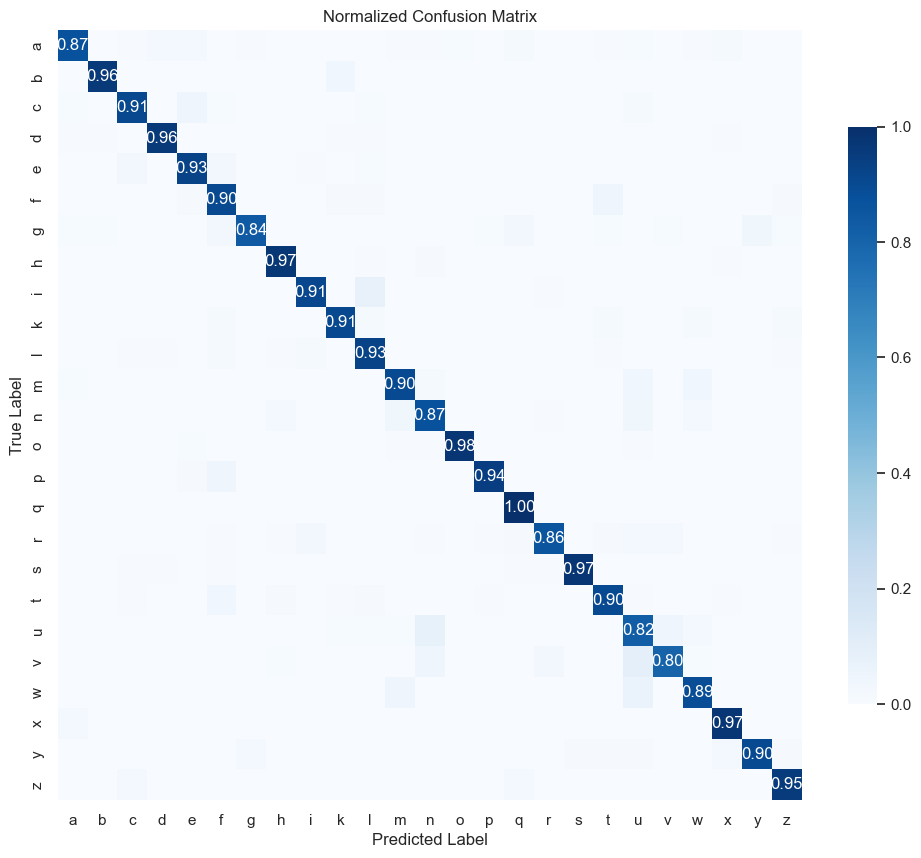

AUC per la classe a: 0.972
AUC per la classe b: 0.985
AUC per la classe c: 0.965
AUC per la classe d: 0.980
AUC per la classe e: 0.980
AUC per la classe f: 0.942
AUC per la classe g: 0.949
AUC per la classe h: 0.983
AUC per la classe i: 0.984
AUC per la classe k: 0.959
AUC per la classe l: 0.940
AUC per la classe m: 0.965
AUC per la classe n: 0.928
AUC per la classe o: 0.991
AUC per la classe p: 0.987
AUC per la classe q: 0.988
AUC per la classe r: 0.945
AUC per la classe s: 0.995
AUC per la classe t: 0.967
AUC per la classe u: 0.882
AUC per la classe v: 0.922
AUC per la classe w: 0.951
AUC per la classe x: 0.968
AUC per la classe y: 0.971
AUC per la classe z: 0.988


In [48]:
precision, recall, f1 = alexnet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = alexnet.confusion_matrix(test_loader) 


def plot_normalized_confusion_matrix(cm, class_names, file_path=None):
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create an array of the same shape as cm_normalized filled with empty strings
    annot = np.empty_like(cm_normalized, dtype=object)
    annot[:] = ''

    # Populate the array with the diagonal values as strings
    for i in range(len(cm_normalized)):
        annot[i, i] = f'{cm_normalized[i, i]:.2f}'
    
    plt.figure(figsize=(12, 10))  # Increase figure size
    sns.heatmap(cm_normalized, annot=annot, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 12}, cbar_kws={'shrink': 0.75})  # Adjust text size and color bar
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    if file_path:
        plt.savefig(file_path, bbox_inches='tight')  # Save with tight layout
    plt.show()



plot_normalized_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

alexnet.plot_precision_recall_curve(test_loader)

## ResNet

In [97]:
resnet = GenericModel('resnet')
print(f'The model has {resnet.numparams()} trainable parameters')

The model has 11189337 trainable parameters


In [14]:
resnet.eval()
with torch.no_grad():
    resnet_test_loss, resnet_test_accuracy = resnet.test_model(test_loader)
    
print('\nNon fine-tuned SqueezeNet:')
print(f'Test Loss: {resnet_test_loss:.3f}, Test Accuracy: {resnet_test_accuracy:.3f}')


Non fine-tuned SqueezeNet:
Test Loss: 3.459, Test Accuracy: 0.028


In [98]:

lr = 0.001 
momentum = 0.9
weight_decay = 0.0001 
exp_name = 'resnet_experiment8' 

'''
resnet_train_losses, resnet_train_accuracies, resnet_val_losses, resnet_val_accuracies = resnet.train_model(train_loader, 
                                                                                             val_loader,
                                                                                             exp_name=exp_name, 
                                                                                             epochs=1000,
                                                                                             lr=lr,
                                                                                             momentum=momentum,
                                                                                             weight_decay=weight_decay)
'''

'\nresnet_train_losses, resnet_train_accuracies, resnet_val_losses, resnet_val_accuracies = resnet.train_model(train_loader, \n                                                                                             val_loader,\n                                                                                             exp_name=exp_name, \n                                                                                             epochs=1000,\n                                                                                             lr=lr,\n                                                                                             momentum=momentum,\n                                                                                             weight_decay=weight_decay)\n'

In [102]:

exp_name = 'resnet_experiment8'
resnet.eval()

with torch.no_grad():
    resnet_test_loss, resnet_test_accuracy = resnet.test_model(test_loader)

test_error = resnet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = resnet_test_loss
metrics['test_accuracy'] = resnet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")


Metrics updated and saved successfully


In [103]:
# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
resnet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

Model loaded successfully
Metrics loaded successfully



In [104]:
print('Fine-tuned ResNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

Fine-tuned ResNet:
Train Loss: 0.714
Train Accuracy: 0.78

Validation Loss: 0.483
Validation Accuracy: 0.864

Test Loss: 0.481
Test Accuracy: 0.852


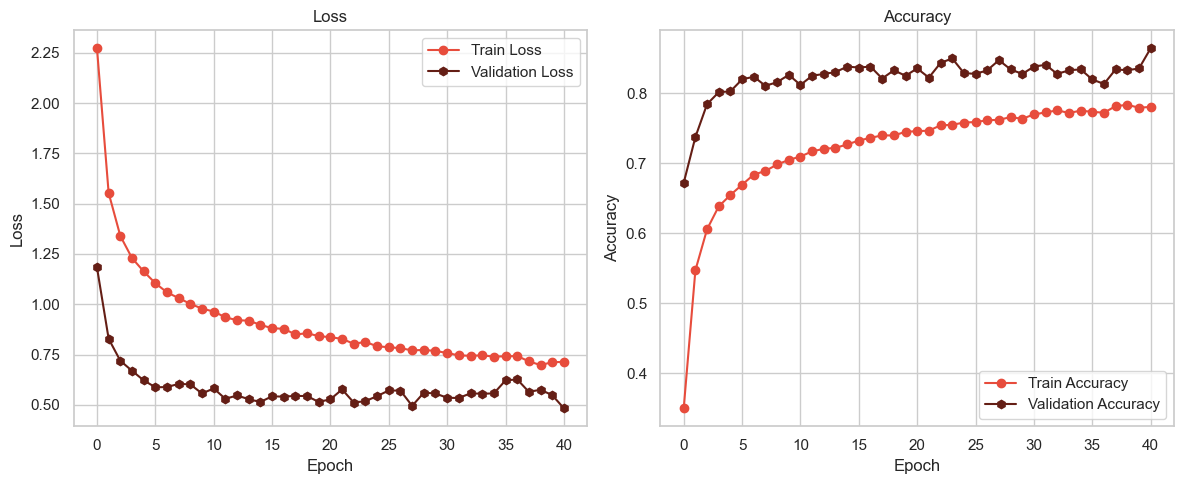

In [78]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, save_path):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, color="#E74C3C", label='Train Loss', marker='o')
    plt.plot(val_losses, color="#641E15", label='Validation Loss', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, color="#E74C3C", label='Train Accuracy', marker='o')
    plt.plot(val_accuracies, color="#641E15", label='Validation Accuracy', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# Ensure train and validation losses and accuracies are lists of float values
train_losses = [float(loss) for loss in metrics['train_loss']]
val_losses = [float(loss) for loss in metrics['val_loss']]
train_accuracies = [float(acc) for acc in metrics['train_accuracy']]
val_accuracies = [float(acc) for acc in metrics['val_accuracy']]

# Plot the metrics
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, f'plots/{exp_name}_accuracy_and_Loss.png')

Precision: 0.864
Recall: 0.832
F1 Score: 0.843


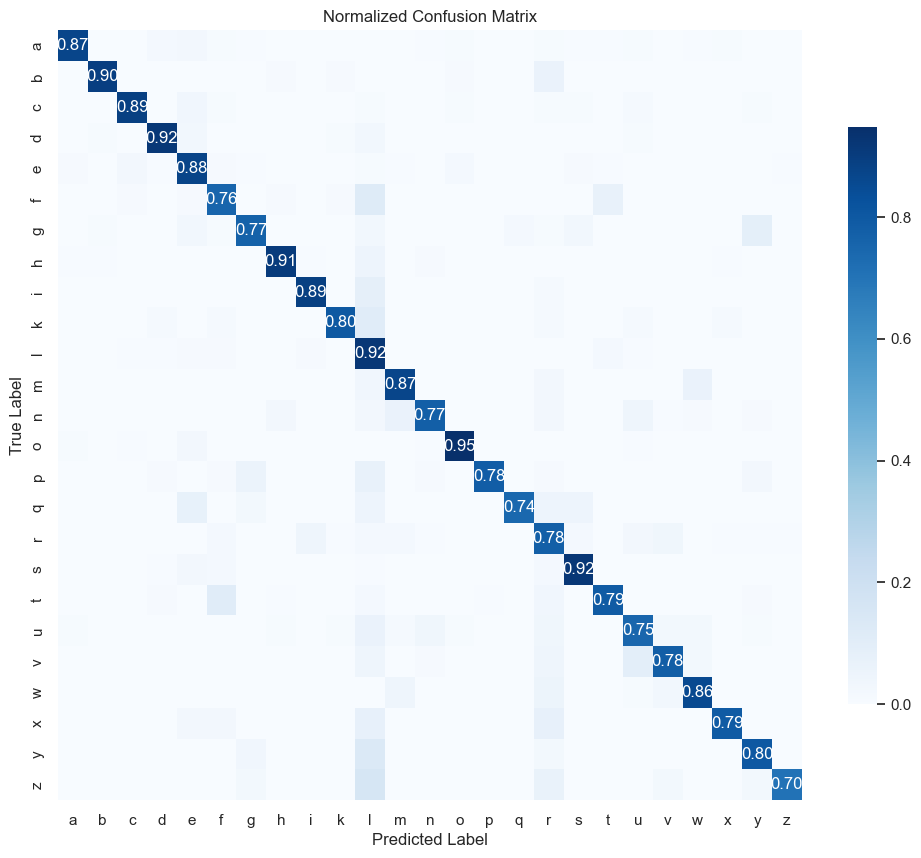

AUC per la classe a: 0.963
AUC per la classe b: 0.971
AUC per la classe c: 0.956
AUC per la classe d: 0.960
AUC per la classe e: 0.971
AUC per la classe f: 0.825
AUC per la classe g: 0.903
AUC per la classe h: 0.964
AUC per la classe i: 0.973
AUC per la classe k: 0.891
AUC per la classe l: 0.913
AUC per la classe m: 0.939
AUC per la classe n: 0.898
AUC per la classe o: 0.984
AUC per la classe p: 0.972
AUC per la classe q: 0.862
AUC per la classe r: 0.894
AUC per la classe s: 0.976
AUC per la classe t: 0.925
AUC per la classe u: 0.821
AUC per la classe v: 0.859
AUC per la classe w: 0.933
AUC per la classe x: 0.907
AUC per la classe y: 0.879
AUC per la classe z: 0.856


In [79]:

precision, recall, f1 = resnet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = resnet.confusion_matrix(test_loader) 

def plot_normalized_confusion_matrix(cm, class_names, file_path=None):
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create an array of the same shape as cm_normalized filled with empty strings
    annot = np.empty_like(cm_normalized, dtype=object)
    annot[:] = ''

    # Populate the array with the diagonal values as strings
    for i in range(len(cm_normalized)):
        annot[i, i] = f'{cm_normalized[i, i]:.2f}'
    
    plt.figure(figsize=(12, 10))  # Increase figure size
    sns.heatmap(cm_normalized, annot=annot, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 12}, cbar_kws={'shrink': 0.75})  # Adjust text size and color bar
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    if file_path:
        plt.savefig(file_path, bbox_inches='tight')  # Save with tight layout
    plt.show()

plot_normalized_confusion_matrix(cm, class_names, file_path='plots/resnet_confusion_matrix.png')



resnet.plot_precision_recall_curve(test_loader)


<h1>SqueezeNet</h1>

In [60]:
squeezenet = GenericModel('squeezenet')
print(f'The model has {squeezenet.numparams()} trainable parameters')

The model has 748249 trainable parameters


In [61]:
squeezenet.eval()
with torch.no_grad():
    squeezenet_test_loss, squeezenet_test_accuracy = squeezenet.test_model(test_loader)
    
print('\nNon fine-tuned SqueezeNet:')
print(f'Test Loss: {squeezenet_test_loss:.3f}, Test Accuracy: {squeezenet_test_accuracy:.3f}')


Non fine-tuned SqueezeNet:
Test Loss: 3.929, Test Accuracy: 0.048


In [62]:

lr = 0.001 
momentum = 0.9
weight_decay = 0.0001 
exp_name = 'squeezenet_experiment1'


squeezenet_train_losses, squeezenet_train_accuracies, squeezenet_val_losses, squeezenet_val_accuracies = squeezenet.train_model(train_loader, 
                                                                                             val_loader,
                                                                                             exp_name=exp_name, 
                                                                                             epochs=100,
                                                                                             lr=lr,
                                                                                             momentum=momentum,
                                                                                             weight_decay=weight_decay)


[Epoch 1/100]
Train Loss: 2.573, Train Accuracy: 0.261 | Val Loss: 1.712, Val Accuracy: 0.456

[Epoch 2/100]
Train Loss: 2.024, Train Accuracy: 0.411 | Val Loss: 1.287, Val Accuracy: 0.613

[Epoch 3/100]
Train Loss: 1.783, Train Accuracy: 0.476 | Val Loss: 1.192, Val Accuracy: 0.650

[Epoch 4/100]
Train Loss: 1.658, Train Accuracy: 0.512 | Val Loss: 1.053, Val Accuracy: 0.698

[Epoch 5/100]
Train Loss: 1.580, Train Accuracy: 0.534 | Val Loss: 1.011, Val Accuracy: 0.701

[Epoch 6/100]
Train Loss: 1.514, Train Accuracy: 0.552 | Val Loss: 1.065, Val Accuracy: 0.694

[Epoch 7/100]
Train Loss: 1.461, Train Accuracy: 0.566 | Val Loss: 0.941, Val Accuracy: 0.715

[Epoch 8/100]
Train Loss: 1.419, Train Accuracy: 0.578 | Val Loss: 0.937, Val Accuracy: 0.720

[Epoch 9/100]
Train Loss: 1.400, Train Accuracy: 0.584 | Val Loss: 0.935, Val Accuracy: 0.729

[Epoch 10/100]
Train Loss: 1.376, Train Accuracy: 0.590 | Val Loss: 0.907, Val Accuracy: 0.724

[Epoch 11/100]
Train Loss: 1.360, Train Accuracy:

In [63]:
exp_name = 'squeezenet_experiment1'
squeezenet.eval()

with torch.no_grad():
    squeezenet_test_loss, squeezenet_test_accuracy = squeezenet.test_model(test_loader)

test_error = squeezenet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = squeezenet_test_loss
metrics['test_accuracy'] = squeezenet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
squeezenet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned SqueezeNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

Metrics updated and saved successfully
Model loaded successfully
Metrics loaded successfully

Fine-tuned SqueezeNet:
Train Loss: 1.22
Train Accuracy: 0.63

Validation Loss: 0.746
Validation Accuracy: 0.766

Test Loss: 0.794
Test Accuracy: 0.77


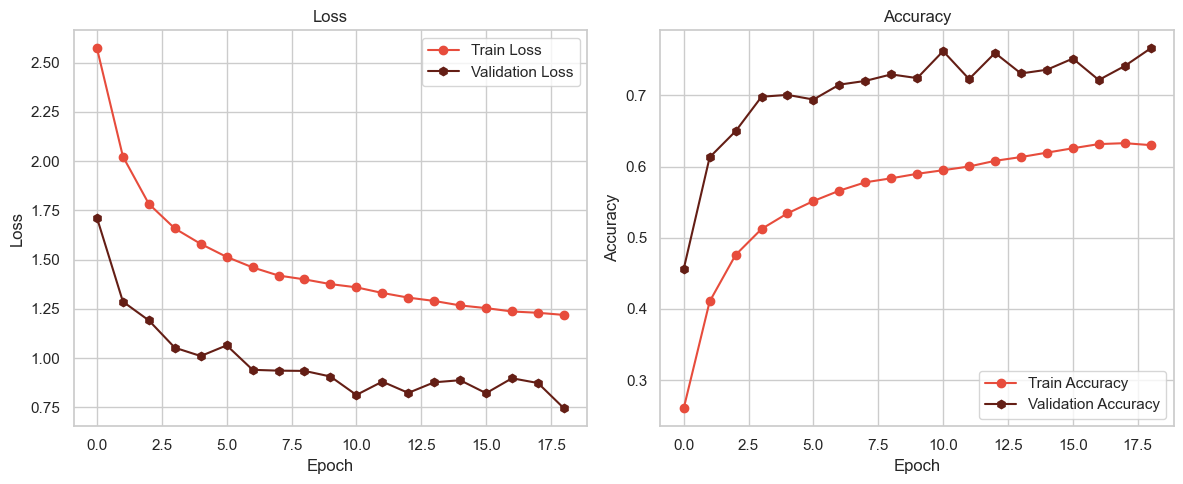

In [64]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, save_path):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, color="#E74C3C", label='Train Loss', marker='o')
    plt.plot(val_losses, color="#641E15", label='Validation Loss', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, color="#E74C3C", label='Train Accuracy', marker='o')
    plt.plot(val_accuracies, color="#641E15", label='Validation Accuracy', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# Ensure train and validation losses and accuracies are lists of float values
train_losses = [float(loss) for loss in metrics['train_loss']]
val_losses = [float(loss) for loss in metrics['val_loss']]
train_accuracies = [float(acc) for acc in metrics['train_accuracy']]
val_accuracies = [float(acc) for acc in metrics['val_accuracy']]

# Plot the metrics
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, f'plots/{exp_name}_accuracy_and_Loss.png')

Precision: 0.826
Recall: 0.766
F1 Score: 0.785


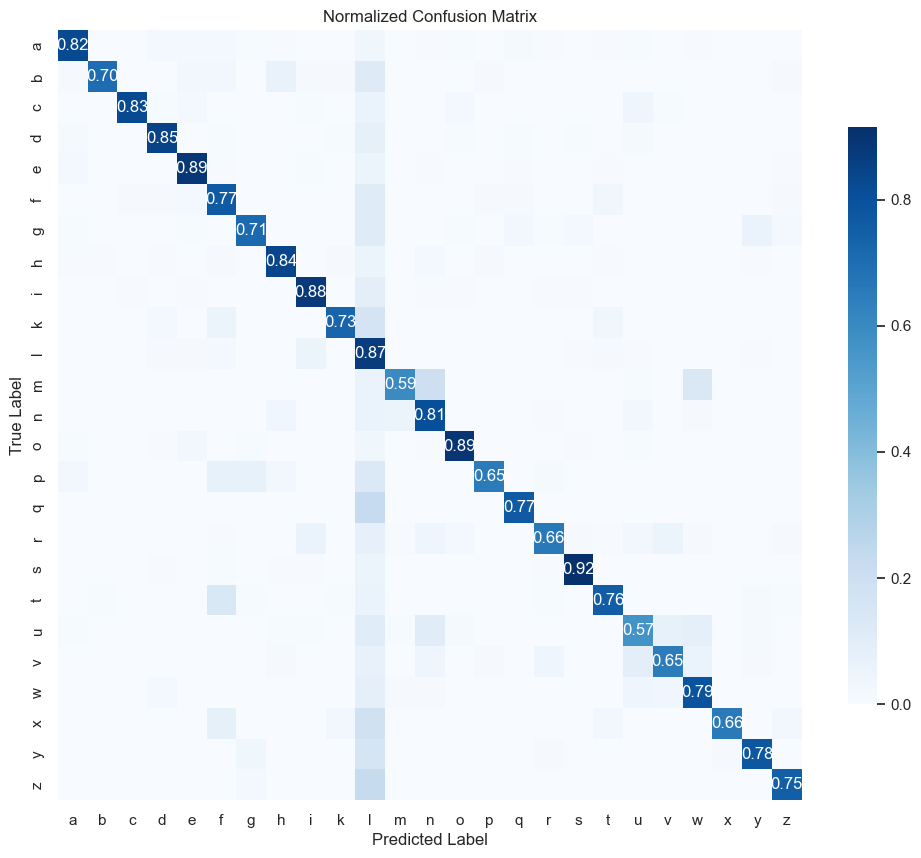

AUC per la classe a: 0.914
AUC per la classe b: 0.876
AUC per la classe c: 0.926
AUC per la classe d: 0.928
AUC per la classe e: 0.944
AUC per la classe f: 0.789
AUC per la classe g: 0.815
AUC per la classe h: 0.921
AUC per la classe i: 0.946
AUC per la classe k: 0.791
AUC per la classe l: 0.852
AUC per la classe m: 0.835
AUC per la classe n: 0.807
AUC per la classe o: 0.965
AUC per la classe p: 0.836
AUC per la classe q: 0.799
AUC per la classe r: 0.804
AUC per la classe s: 0.961
AUC per la classe t: 0.881
AUC per la classe u: 0.671
AUC per la classe v: 0.756
AUC per la classe w: 0.806
AUC per la classe x: 0.832
AUC per la classe y: 0.827
AUC per la classe z: 0.792


In [66]:
precision, recall, f1 = squeezenet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = squeezenet.confusion_matrix(test_loader) 
class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']  

plot_normalized_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

squeezenet.plot_precision_recall_curve(test_loader)

<h1>Testing<h1>

Model loaded successfully


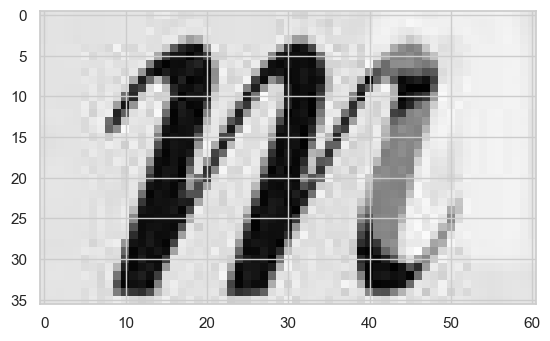

The image is classified as: m


In [19]:
import os
import pickle
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

# Funzione per caricare e trasformare l'immagine
def load_image(image_path, device):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    plt.imshow(image)
    plt.show()
    image = transform(image).unsqueeze(0).to(device)  
    return image

# Funzione per classificare l'immagine
def classify_image(image_path, model, class_names, device):
    image = load_image(image_path, device)
    model.eval() 
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        class_name = class_names[predicted.item()]
        return class_name

# Carica il modello
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weights = torch.load(os.path.join('models', 'alexnet_experiment2.pth'))
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
alexnet.load_state_dict(model_weights, strict=False)
alexnet.to(device)  # Sposta il modello sulla device corretta
print("Model loaded successfully")

# Path dell'immagine da classificare
image_path = r'C:\Users\orazi\OneDrive\Desktop\tesi\prova\alfabeto-corsivo-minuscolo-a-z-2m98ac9_character_12.png'

# Classifica l'immagine
class_name = classify_image(image_path, alexnet, class_names, device)
print(f'The image is classified as: {class_name}')


<h1>classificazione di caratteri in cartelle</h1>

In [15]:
import os
import shutil
from PIL import Image
import torch
import numpy as np
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

def load_image(image_path, device):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = transform(image).unsqueeze(0).to(device) 
    return image

# Function to classify an image and return class name and confidence
def classify_image(image_path, model, class_names, device):
    image = load_image(image_path, device)
    model.eval()  
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        class_name = class_names[predicted.item()]
        return class_name, confidence.item()

# Function to calculate dynamic thresholds based on confidences
def calculate_dynamic_thresholds(confidences, class_names, sigma_factor=1):
    confidence_dict = {i: [] for i in range(len(class_names))}
    
    for predicted_class, confidence in confidences:
        class_idx = class_names.index(predicted_class)
        confidence_dict[class_idx].append(confidence)
    
    thresholds = {}
    for class_idx, scores in confidence_dict.items():
        if scores:
            mean_conf = np.mean(scores)
            std_conf = np.std(scores)
            thresholds[class_idx] = max(0.5, mean_conf - sigma_factor * std_conf)
        else:
            thresholds[class_idx] = 0.5  

    return thresholds

# Function to gather confidences for all images in a directory
def gather_confidences(main_folder, model, class_names, device):
    confidences = []

    for subdir, _, files in os.walk(main_folder):
        for file in files:
            image_path = os.path.join(subdir, file)
            if image_path.endswith(('.jpg')):
                predicted_class, confidence = classify_image(image_path, model, class_names, device)
                confidences.append((predicted_class, confidence))

    return confidences

# Function to classify images in a directory
def classify_images_in_directory(main_folder, output_folder, model, class_names, dynamic_thresholds, device):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    low_confidence_folder = os.path.join(output_folder, 'low_confidence')
    if not os.path.exists(low_confidence_folder):
        os.makedirs(low_confidence_folder)
    
    for subdir, _, files in os.walk(main_folder):
        for file in files:
            image_path = os.path.join(subdir, file)
            if image_path.endswith(('.jpg')):
                class_name, confidence = classify_image(image_path, model, class_names, device)
                class_idx = class_names.index(class_name)
                confidence_threshold = dynamic_thresholds.get(class_idx, 0.5)
                if confidence < confidence_threshold:
                    dest_folder = low_confidence_folder
                else:
                    dest_folder = os.path.join(output_folder, class_name)
                if not os.path.exists(dest_folder):
                    os.makedirs(dest_folder)
                shutil.copy(image_path, os.path.join(dest_folder, file))


# Load the model and weights
model_weights = torch.load(os.path.join('models', 'alexnet_experiment2.pth'), map_location=device)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
alexnet.load_state_dict(model_weights, strict=False)
alexnet.to(device)  # Move the model to the correct device
print("Model loaded successfully")

main_folder = r'C:\Users\orazi\OneDrive\Desktop\tesi\datiT\dati5-1'
output_folder = r'C:\Users\orazi\OneDrive\Desktop\tesi\datiT\data\e'

class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']

confidences = gather_confidences(main_folder, alexnet, class_names, device)

dynamic_thresholds = calculate_dynamic_thresholds(confidences, class_names)

classify_images_in_directory(main_folder, output_folder, alexnet, class_names, dynamic_thresholds, device)


Model loaded successfully


In [60]:
def load_images_into_dataframe(base_path):
    data = []

    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    try:
                        image = Image.open(file_path)
                        image_array = np.array(image)
                        data.append({'image': image_array, 'label': folder_name})
                    except Exception as e:
                        print(f"Errore nel caricamento dell'immagine {file_path}: {e}")

    df = pd.DataFrame(data)
    return df

def save_dataframe_to_hdf5(df, hdf5_path):
    df.to_hdf(hdf5_path, key='df', mode='w')

def load_dataframe_from_hdf5(hdf5_path):
    df = pd.read_hdf(hdf5_path, key='df')
    return df

# Esempio di utilizzo:


In [61]:
manuscript = r'C:\Users\orazi\OneDrive\Desktop\tesi\datiT\prova'
df = load_images_into_dataframe(manuscript)
print(f"Caricate {len(df)} immagini nel DataFrame.")
print(df.head())
hdf5_path = 'SubjectDataset.h5'
save_dataframe_to_hdf5(df, hdf5_path)

Caricate 1884 immagini nel DataFrame.
                                               image label
0  [[255, 249, 249, 254, 255, 255, 247, 254, 255,...     a
1  [[253, 255, 255, 255, 251, 254, 241, 255, 255,...     a
2  [[255, 244, 255, 254, 255, 255, 247, 255, 254,...     a
3  [[255, 247, 255, 255, 255, 247, 236, 199, 173,...     a
4  [[251, 255, 255, 249, 255, 247, 237, 179, 127,...     a


In [67]:
df = load_dataframe_from_hdf5(hdf5_path)


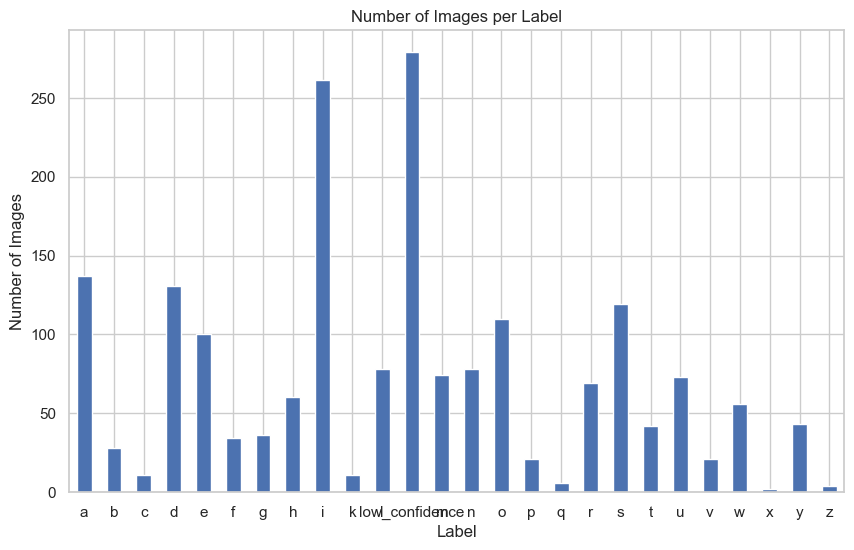

In [68]:
# Group by the label column and count the occurrences
label_counts = df['label'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Number of Images per Label')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.show()

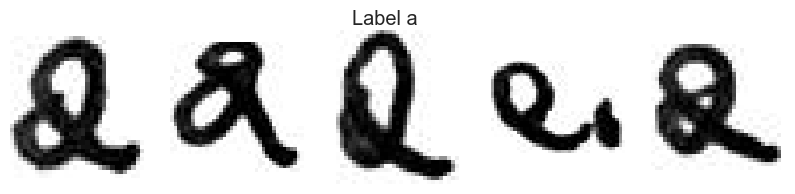

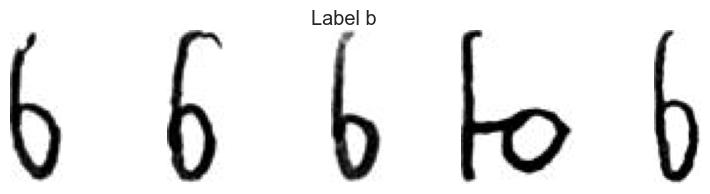

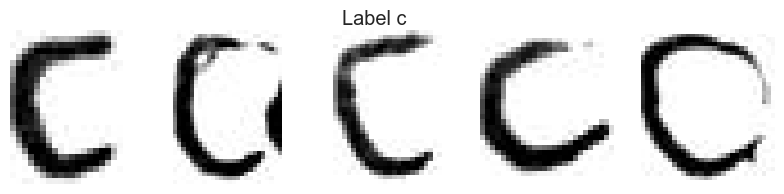

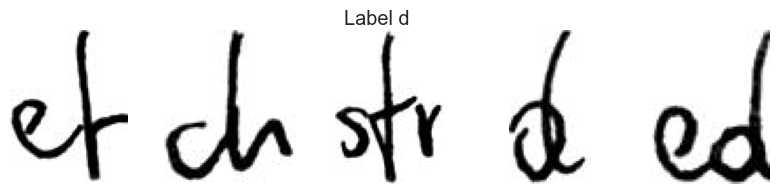

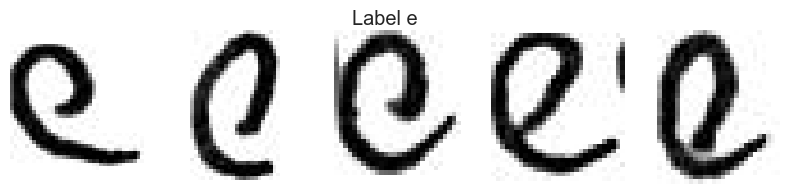

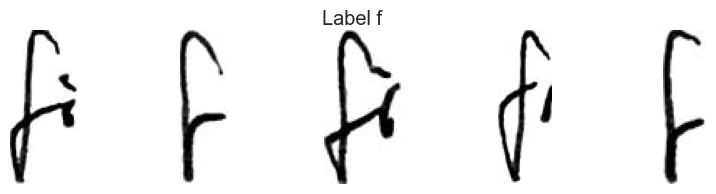

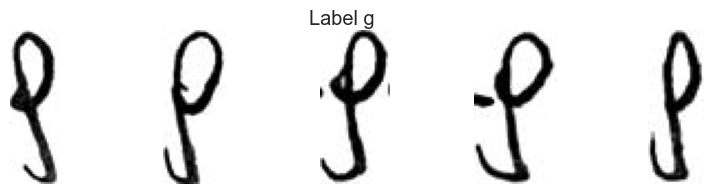

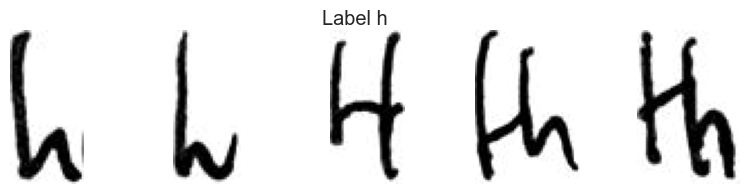

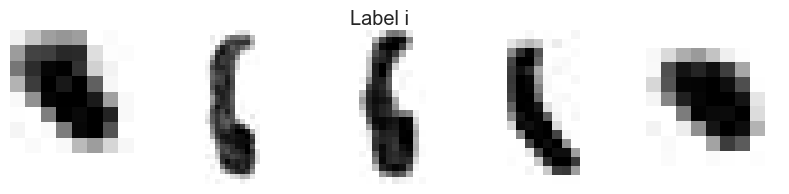

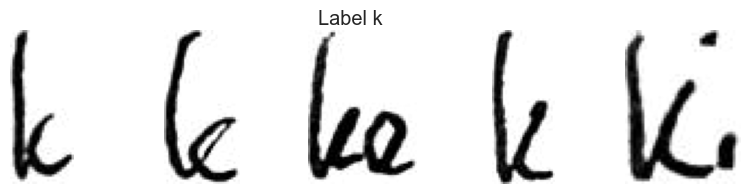

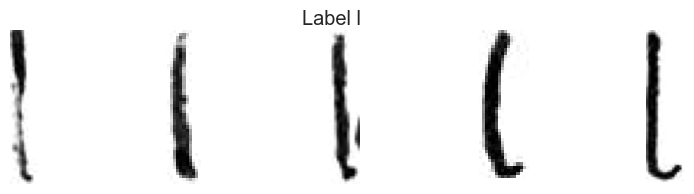

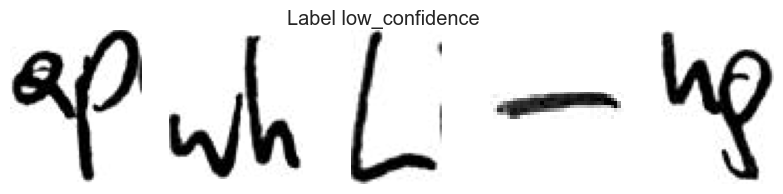

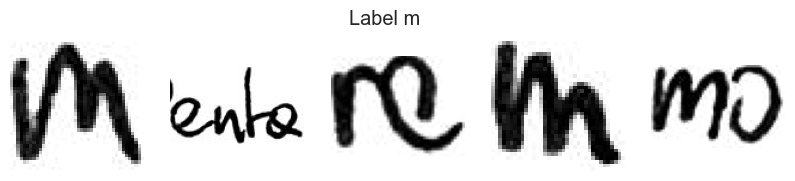

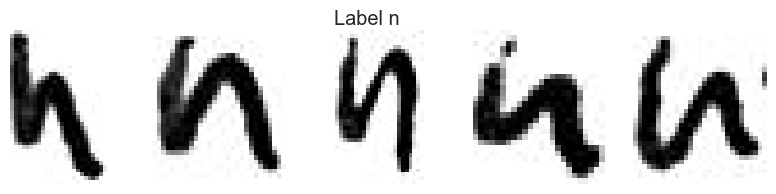

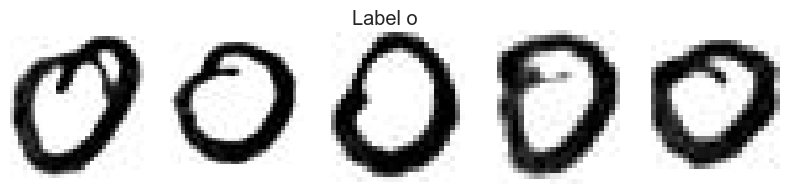

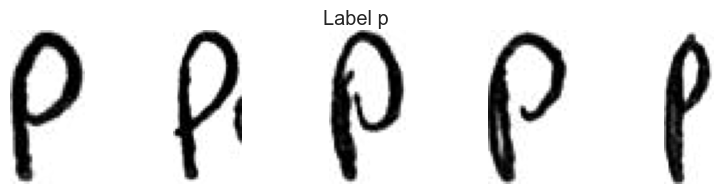

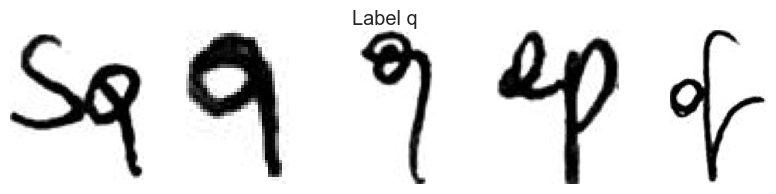

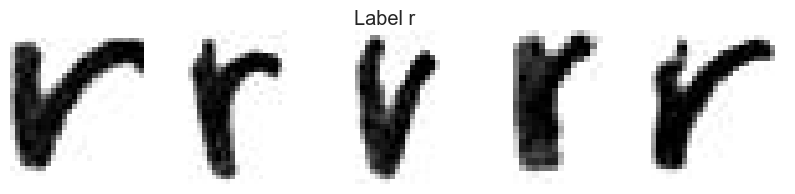

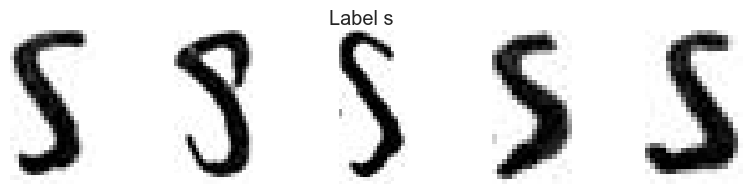

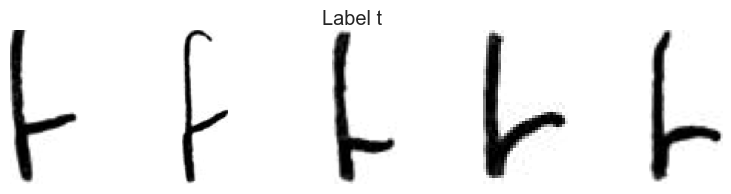

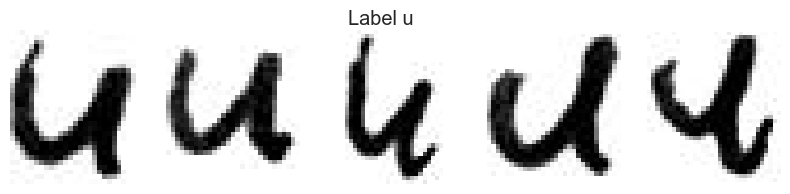

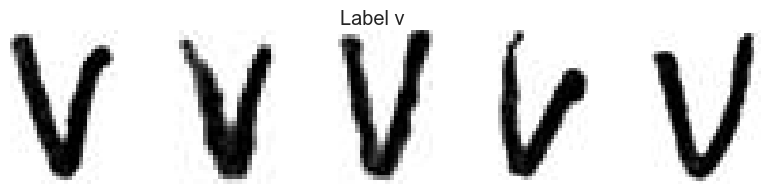

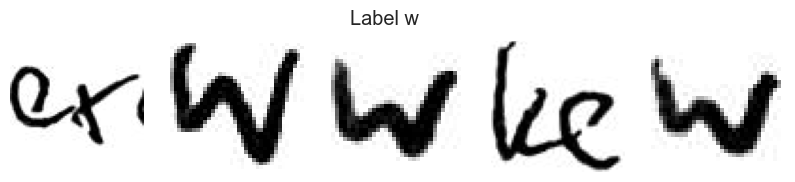

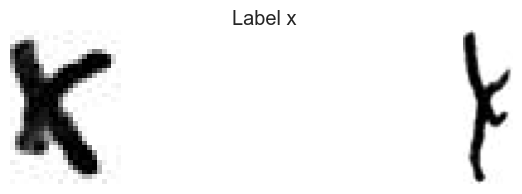

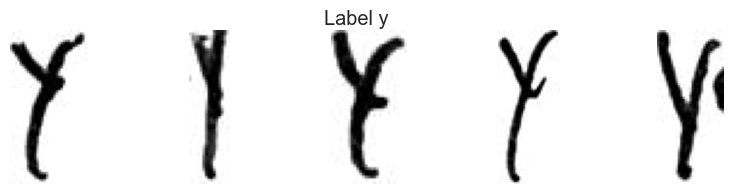

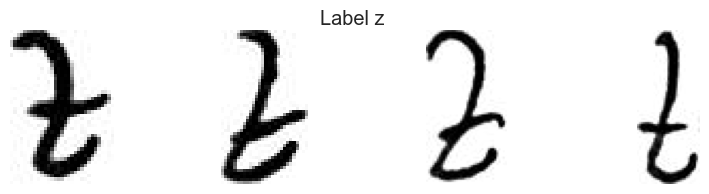

In [69]:
# Group by the label column
grouped = df.groupby('label')

# Function to plot images
def plot_images(images, label, max_images=5):
    plt.figure(figsize=(10, 2))
    plt.suptitle(f'Label {label}')
    for i, img in enumerate(images):
        plt.subplot(1, min(len(images), max_images), i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()

# Loop through each label and plot images
for label, group in grouped:
    images = group['image'].tolist()
    plot_images(images[:5], label)

<h1>Estrazione Vettori Feature<h1>

In [39]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import os
import json

# Ensure the dataframe includes the 'subject' column
df['subject'] = df.apply(lambda row: row['subject'], axis=1)

# Dictionary mapping numbers to letters, excluding 'j'
letters = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']
num_to_letter = {i: letter for i, letter in enumerate(letters)}

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment=False):
        self.transform = transform
        self.augment = augment
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_array = row['image']
        if len(image_array.shape) == 3 and image_array.shape[2] == 1:
            image_array = image_array.squeeze(-1)
        image = Image.fromarray(image_array.astype(np.uint8)).convert('RGB')
        label = row['label_int']
        subject = row['subject']

        if self.transform:
            image = self.transform(image)

        return image, label, subject

def collate_fn(batch):
    images, labels, subjects = zip(*batch)
    return torch.stack(images), torch.tensor(labels), subjects

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    subjects = []
    device = next(model.parameters()).device
    with torch.no_grad():
        for batch in dataloader:
            inputs, lbls, subs = batch
            inputs = inputs.to(device)
            feats = model.extract_features(inputs)
            features.extend(feats.cpu().numpy())
            labels.extend(lbls.cpu().numpy())
            subjects.extend(subs)
    return np.array(features), np.array(labels), np.array(subjects)

def save_features(features, labels, subjects, filename):
    data = []
    for feature, label, subject in zip(features, labels, subjects):
        letter = num_to_letter[label]
        data.append({
            'subject': subject,
            'letter': letter,
            'features': json.dumps(feature.tolist())
        })
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

# Prepare data transformation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7838, 0.7838, 0.7838], std=[0.3301, 0.3301, 0.3301])
])

# Load data and prepare datasets
main_folder = 'dataset'
df, label_names, alphabet = load_images_from_subfolders(main_folder)
df = prepare_data(df)
df['label_int'] = df['label'].apply(lambda x: np.argmax(x))

# Split dataset into training and test sets
df_train, df_test = create_train_test_dataframe(df)
train_dataset = CustomDataset(df_train, transform=val_transform)
test_dataset = CustomDataset(df_test, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Load the trained ResNet model
class GenericModel(LetterClassifier):
    def __init__(self, model_architecture, num_classes=25):
        super(GenericModel, self).__init__(num_classes=num_classes)
        self.model = self.get_model(model_architecture, num_classes)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def get_model(self, model_architecture, num_classes):
        if model_architecture == 'resnet':
            model = resnet18(weights=ResNet18_Weights.DEFAULT)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
            self.feature_extractor = nn.Sequential(*list(model.children())[:-1])
        else:
            raise ValueError(f"Model architecture '{model_architecture}' not recognized")
        return model

    def extract_features(self, x):
        self.model.eval()
        with torch.no_grad():
            features = self.feature_extractor(x)
            features = features.view(features.size(0), -1)
        return features

model = GenericModel('resnet')
model_weights = torch.load(os.path.join('models', f'resnet_experiment6.pth'))
model.load_state_dict(model_weights, strict=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Extract and save features for training set
train_features, train_labels, train_subjects = extract_features(model, train_loader)
save_features(train_features, train_labels, train_subjects, 'featureVectors/train_features2.csv')

# Extract and save features for test set
test_features, test_labels, test_subjects = extract_features(model, test_loader)
save_features(test_features, test_labels, test_subjects, 'featureVectors/test_features2.csv')

print("Training and test features extracted and saved to 'train_features.csv' and 'test_features.csv'")



Train set: (14680, 5), Test set: (3671, 5)
Training and test features extracted and saved to 'train_features.csv' and 'test_features.csv'
